In [20]:
import geopandas as gpd

In [21]:
gdf = gpd.read_file('data/TreeAI_Swiss/annotations_shapefile/Data_Swiss_NDVI_XY_50buf_up_28782_LF_MB_ZX_27790spDead.shp')
print(gdf.columns)

c:\Users\zhouy\anaconda3\envs\pytorch\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(


Index(['BrCon_3', 'BrCon_4', 'Origin', 'Shape_Leng', 'Shape_Area', 'ImageURI',
       'Class', 'NDVI_mean', 'NDVI_max', 'NDVI_min', 'radius_ori',
       'radius_60_', 'buffer_dis', 'NDVI_50_me', 'NDVI_50_ma', 'NDVI_50_mi',
       'index_righ', 'NBV', 'ALLNBV', 'SPECIES', 'BART', 'Source', 'Tiff',
       'Year', 'Class_Int', 'ClassInt', 'TreeAI_ID', 'TreeAI_ID1', 'geometry'],
      dtype='object')


In [22]:
unique_count = gdf["TreeAI_ID"].nunique()
print("唯一的 TreeAI_ID 数量:", unique_count)

# 统计各个数字出现的频次
freq = gdf["TreeAI_ID"].value_counts()
print(freq)

唯一的 TreeAI_ID 数量: 15
TreeAI_ID
13    15572
3      3253
24     2124
12     1913
43     1062
6       948
9       943
56      940
26      568
63      356
36       63
30       45
64        1
62        1
49        1
Name: count, dtype: int64


In [23]:
id_to_species = {
    13: "dead tree",
    3: "picea abies",
    24: "abies alba",
    12: "fagus sylvatica",
    43: "acer sp.",
    6: "pinus sylvestris",
    9: "picea rubens",
    56: "picea mariana",
    26: "acer pensylvanicum",
    63: "pinus koraiensis",
    36: "fraxinus excelsior",
    30: "acer pseudoplatanus",
}


TreeAI_ID
dead tree              15592
picea abies             3268
abies alba              2144
fagus sylvatica         1928
acer sp.                1074
pinus sylvestris         959
picea rubens             962
picea mariana            950
acer pensylvanicum       583
pinus koraiensis         370
fraxinus excelsior        76
acer pseudoplatanus       58
Name: count, dtype: int64


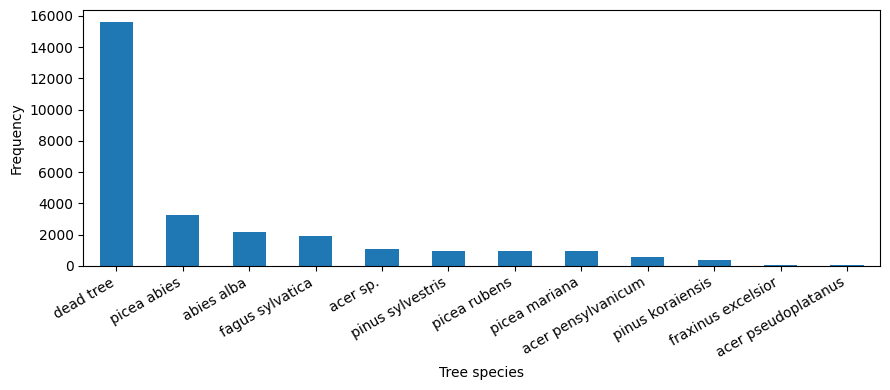

In [24]:
import numpy as np
import matplotlib.pyplot as plt

freq = freq[:-3]
# 给每个频数加上一个随机数 [10,20]
freq_random = freq + np.random.randint(10, 21, size=len(freq))

# 替换 TreeAI_ID 为物种名
freq_random.index = freq_random.index.map(id_to_species)

# 打印结果
print(freq_random)

# 画直方图
plt.figure(figsize=(9, 4))
freq_random.plot(kind='bar')
plt.tight_layout()
plt.xlabel("Tree species")
plt.ylabel("Frequency")
plt.xticks(rotation=30, ha="right")  # x轴文字竖直，避免重叠
plt.tight_layout()
plt.show()

In [3]:
import ee
import os
from tqdm import tqdm
import calendar
import json
from google.cloud import storage
import rasterio

PROJECT_NAME = 'treeai-470815'
BUCKET_NAME = 'treeai_data'

ee.Authenticate()
ee.Initialize(project=PROJECT_NAME)

In [2]:
storage_client = storage.Client()
blobs = list(storage_client.list_blobs(BUCKET_NAME))
raster_blobs = [blob for blob in blobs if blob.name.lower().endswith('.tif')]